# Variational Autoencoder (VAE) to generate handwritten digits
* Author: Johannes Maucher - adapted from [keras autoencoder tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).
* Last Update: 14.01.2018
* Reference: [D.P. Kingma, M. Welling: Autoencoder Variational Bayes](https://arxiv.org/abs/1312.6114)

## Autoencoder

An autoencoder consists of an encoder- and a decoder-module. The encoder maps each input $\mathbf{x}$ to a latent representation $\mathbf{y}$, such that the decoder network is able to calculate a reconstruction $\mathbf{z}$ from $\mathbf{y}$, whereby $\mathbf{z}$ must be as close as possible to the input $\mathbf{x}$. The weights of the encoder- and decoder- module are learned by minimizing a loss-function, which measures the difference between the reconstruction $\mathbf{z}$ and the original $\mathbf{x}$. For this standard gradient descent supervised learning algorithms, such as backpropagation can be applied. Even though the inputs must not be labeled (the target ist the input itself)! 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoder.png" width="450" class="center">

Usually the latent representation $\mathbf{y}$ is much smaller, than the original $\mathbf{x}$ and it's reconstruction $\mathbf{z}$. Hence, the entire process realizes a standard lossy compression, such as e.g. jpeg-encoding of images.

After training of an autoencoder, all inputs, which are similar to inputs seen in the training phase, will be reconstructed well. However, inputs, which are totally different from the training-samples won't be reconstructed well.  

For example, if the autoencoder has been trained with many images from rabbits and geese, these two types of animals will be reconstructed well, but if no elephants has been in the training data, the trained network won't be able to reconstruct elephants sufficiently.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoderGans.png" width="450" class="center">

## Variational Autoencoder
An autoencoder, as shortly described above, is not a generative model. It just tries to reconstruct the input, but it is not able to generate new data, e.g. new rabbit images or new geese images. This is where the **Variational Autoencoder (VAE)** comes in. A variational autoencoder is a generative model. A VAE, which has been trained with rabbit and geese-images is able to generate new rabbit- and geese images. A VAE, which has been trained with handwritten digit images is able to write new handwritten digits, etc. 

In general, if the probability distribution of one or multiple random variable(s) is known, then new samples, which arise from this distribution can be generated. For example, if the parameters *mean* and *standard-deviation* of a Gaussian-distributed random variable are known, then new samples can be generated, which correspond to this distribution. 

Based on this concept, a standard autoencoder can be modified to a generative model - the Variational Autoencoder - as follows: Instead of mapping the input $\mathbf{x}$ to a latent representation $\mathbf{y}$, the Encoder modul maps the input to a probability distribution. More concrete: A type of probability distribution (e.g. a Gaussian Normal Distribution) is presumed, and the output of the encoder are the concrete parameters of this distribution (e.g. *mean* and *standard deviation* for Gaussian distribution type). Then a concrete sample is generated from this distribution. This sample constitutes the input to the decoder.

The weights of the encoder and decoder-module are learned such that the output of the decoder is as close as possible to input - like in the case of an autoencoder, but now with the new process in the latent layer: parameter estimation and sampling.

![Variational Autoencoder](./Pics/variationalAutoencoder.png)

  

In [1]:
#!pip install keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import losses

In [3]:
from os import environ
environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [5]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [9]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [10]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

In [11]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [12]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/50


TypeError: in user code:

    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:237 __call__
        self._loss_metric.update_state(
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:378 update_state  **
        with ops.control_dependencies([value_sum]):
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:5359 control_dependencies
        return get_default_graph().control_dependencies(control_inputs)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:359 control_dependencies
        self.control_captures.add(graph_element)
    /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/keras/engine/keras_tensor.py:260 __hash__
        raise TypeError('Tensors are unhashable. (%s)'

    TypeError: Tensors are unhashable. (KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum_2/Sum:0', description="created by layer 'tf.math.reduce_sum_2'"))Instead, use tensor.ref() as the key.


In [19]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

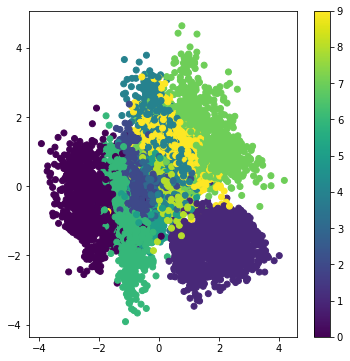

In [20]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [21]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

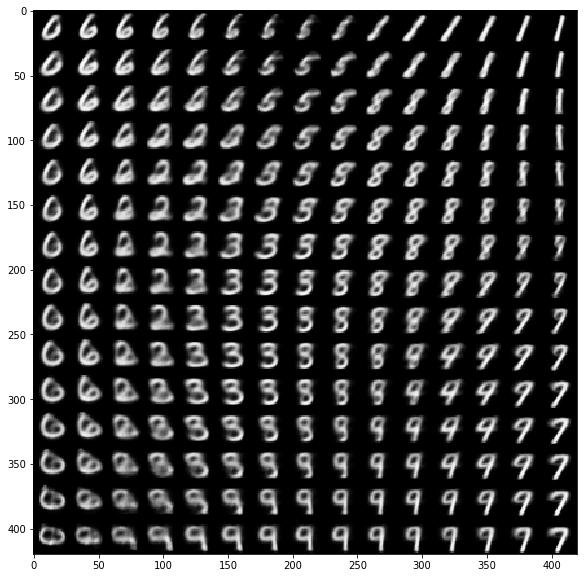

In [22]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

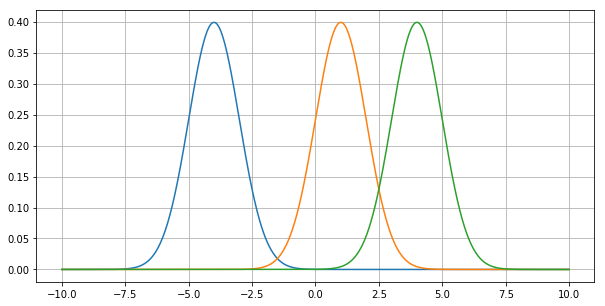

<Figure size 432x288 with 0 Axes>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
plt.figure(figsize=(10,5))
x_axis = np.arange(-10, 10, 0.001)
Mean1 = -4
SD1 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean1,SD1))
Mean2 = 1
SD2 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean2,SD2))
Mean3 = 4
SD3 = 1.
plt.plot(x_axis, norm.pdf(x_axis,Mean3,SD3))
plt.grid(True)
plt.show()
plt.savefig('mixtureOfgaussians0.png')